## S3B. Decomposition Consistency between Score Types

We can also check how consistent each score type is after running the full Tensor-cell2cell pipeline. The [CorrIndex](https://doi.org/10.1016/j.sigpro.2022.108457) provides a dissimilarity metric that can compare decompositions of the same rank. 

In [1]:
from collections import defaultdict
import itertools
import os

import matplotlib

import numpy as np
import pandas as pd
import torch

import liana as li
import cell2cell as c2c
from cell2cell.tensor.metrics import correlation_index

In [2]:
if torch.cuda.is_available():
    import tensorly as tl
    tl.set_backend('pytorch')
    device = 'cuda:0'
else:
    device = 'cpu'

In [3]:
data_folder = '../../data/liana-outputs/'
output_folder = '../../data/tc2c-outputs/'
c2c.io.directories.create_directory(output_folder)

../../data/tc2c-outputs/ already exists.


First, let's load the LIANA scores for each sample and score type:

In [4]:
liana_res = pd.read_csv(data_folder + 'LIANA_by_sample.csv')
sorted_samples = sorted(liana_res['sample_new'].unique())

Next, we can generate and decompose the tensor as in [Tutorial 03](./03-Generate-Tensor.ipynb) and [Tutorial 04](./04-Perform-Tensor-Factorization) respectively, but for each magnitude rank score separately. We will use the rank identified by the consensus magnitude score in Tutorial 04. 

In [5]:
tf_optimization_dict = {'regular': {'runs': 1, 
                                         'tol': 10e-7, 
                                           'n_iter_max': 100}, 
                            'robust': {'runs': 100, 
                                         'tol': 10e-8, 
                                           'n_iter_max': 500}}

def run_tensor_pipeline(liana_res, score_type, rank, 
                       tf_optimization = 'robust'):
    # build tensor
    tensor = li.multi.to_tensor_c2c(liana_res=liana_res, # LIANA's dataframe containing results
                                    sample_key='sample_new', # Column name of the samples
                                    source_key='source', # Column name of the sender cells
                                    target_key='target', # Column name of the receiver cells
                                    ligand_key='ligand_complex', # Column name of the ligands
                                    receptor_key='receptor_complex', # Column name of the receptors
                                    score_key=score_type, # Column name of the communication scores to use
                                    non_negative = True, # set negative values to 0
                                    inverse_fun=lambda x: x, # Transformation function -- don't invert because it's not a rank score
                                    non_expressed_fill=None, # Value to replace missing values with 
                                    how='outer', # What to include across all samples
                                    lr_fill=np.nan, # What to fill missing LRs with 
                                    cell_fill = np.nan, # What to fill missing cell types with 
                                    outer_fraction=1/3., # Fraction of samples as threshold to include cells and LR pairs.
                                    lr_sep='^', # How to separate ligand and receptor names to name LR pair
                                    context_order=sorted_samples, # Order to store the contexts in the tensor
                                    sort_elements=True # Whether sorting alphabetically element names of each tensor dim. Does not apply for context order if context_order is passed.
                                   )
    # get metadata
    element_dict = defaultdict(lambda: 'Unknown')
    context_dict = element_dict.copy()
    context_dict.update({'HC1' : 'Control',
                         'HC2' : 'Control',
                         'HC3' : 'Control',
                         'M1' : 'Moderate COVID-19',
                         'M2' : 'Moderate COVID-19',
                         'M3' : 'Moderate COVID-19',
                         'S1' : 'Severe COVID-19',
                         'S2' : 'Severe COVID-19',
                         'S3' : 'Severe COVID-19',
                         'S4' : 'Severe COVID-19',
                         'S5' : 'Severe COVID-19',
                         'S6' : 'Severe COVID-19',
                        })
    dimensions_dict = [context_dict, None, None, None]
    meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, None, None, None],
                                              fill_with_order_elements=True
                                             )
    
    # decompose tensor
    tensor.to_device(device)
    tensor.compute_tensor_factorization(rank=rank,
                                        init='random', # Initialization method of the tensor factorization
                                        svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                        random_state=0, # Random seed for reproducibility
                                        normalize_loadings=True,
                                        runs=tf_optimization_dict[tf_optimization]['runs'],
                                        tol=tf_optimization_dict[tf_optimization]['tol'],
                                        n_iter_max=tf_optimization_dict[tf_optimization]['n_iter_max']
                                       )
    return tensor

In [6]:
tensor_magnitude = c2c.io.read_data.load_tensor(os.path.join(output_folder, 'BALF-Tensor_decomposed.pkl'))
magnitude_scores = ['lr_means', 'expr_prod', 'lrscore', 'lr_probs']

/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [8]:
tensors_individual = {}
# calculate on each magnitude score type separately
for score_type in magnitude_scores:
    ti = run_tensor_pipeline(liana_res = liana_res,
                             score_type = score_type,
                             rank = tensor_magnitude.rank, 
                             tf_optimization = 'robust')
    ti.to_device('cpu') # ensures can be pickled properly
    tensors_individual[score_type] = ti
c2c.io.export_variable_with_pickle(tensors_individual, output_folder + '/BALF-Tensor_individualscores.pkl')

tensors_individual = c2c.io.read_data.load_variable_with_pickle(output_folder + '/BALF-Tensor_individualscores.pkl')

Next, we can calculate the similarity between each score type's deomposition output based on the CorrIndex metric. For more information on the CorrIndex, as well as similar analyses on decomposition consistency, see Figure 3A of this [paper](https://doi.org/10.1038/s41467-022-31369-2):

In [9]:
corrindex_res = pd.DataFrame(columns = ['score_type_1', 'score_type_2', 'Similarity'])

# calculate corrindex pairwise between score types
for idx, score_type_comparison in enumerate(itertools.permutations(tensors_individual, 2)):
    tensor_1 = tensors_individual[score_type_comparison[0]]
    tensor_2 = tensors_individual[score_type_comparison[1]]
    corrindex = correlation_index(tensor_1.factors, tensor_2.factors)
    similarity = 1 - corrindex
    
    corrindex_res.loc[idx, :] = list(score_type_comparison) + [similarity]

# formatting
corrindex_res = corrindex_res.pivot(index='score_type_1', columns='score_type_2', values = 'Similarity')
corrindex_res.columns = corrindex_res.columns.tolist()
corrindex_res.index = corrindex_res.index.tolist()
np.fill_diagonal(corrindex_res.values, 1)
for col_name in corrindex_res.columns:
    corrindex_res[col_name] = corrindex_res[col_name].astype(float)
    
method_name_map = {'expr_prod': 'Connectome/NATMI', 
                  'lr_means': 'CellPhoneDB', 
                  'lr_probs': 'CellChat', 
                  'lrscore': 'SingleCellSignalR'}
corrindex_res.columns = corrindex_res.columns.map(method_name_map).tolist()
corrindex_res.index = corrindex_res.index.map(method_name_map).tolist()

Interaction space detected as a distance matrix


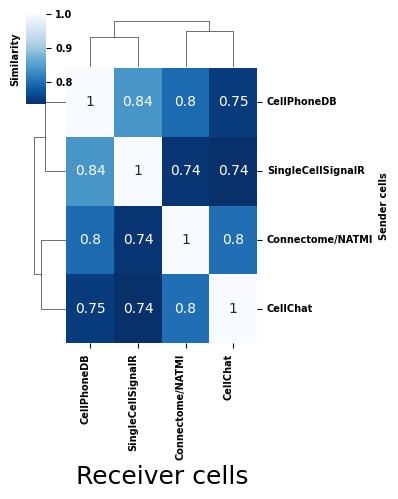

In [10]:
cm = c2c.plotting.clustermap_cci(corrindex_res,
                                 method='ward',
                                 optimal_leaf=True,
                                 metadata=None,
                                 title='',
                                 cbar_title='Similarity', 
                                 cmap='Blues_r',
                                 vmax=1.,
#                                  vmin=0.,
                                 annot=True, 
                                 dendrogram_ratio=0.15,
                                figsize=(4,5))

font = matplotlib.font_manager.FontProperties(weight='bold', size=7)
for ax in [cm.ax_heatmap, cm.ax_cbar]:
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(font)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(font)

    text = ax.yaxis.label
    text.set_font_properties(font)

Given the high overall similarity between score types, we see that Tensor-cell2cell's decomposition tends to capture consistent patterns across samples, smoothing over some of the inconsistencies in communication scores that we saw at the individual sample level in [Tutorial 02](./02-Infer-Communication-Scores.ipynb) 